In [1]:
import commonfunctions as cf # this a custom module found the commonfunctions.py
import cv2
import numpy as np
import os


In [2]:
# Function to perform the perspective transformation
def perspective_transform(img,binary,bubbleId=1):

    if img is None:
        print(f"Error: Unable to load the image.")
    else:
        # Convert the image to grayscale
        binary_image=0
        if binary==0:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply thresholding to create a binary image
            _, binary_image = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
        else :
            binary_image=img
        # cf.show_images([binary_image])
        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
        # print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])

        # Define the destination points for the perspective transformation
        dst_points = np.float32([[0, img.shape[0]], [img.shape[1], img.shape[0]], [0, 0], [img.shape[1], 0]])

        # Calculate the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(sorted_corners.astype(np.float32), dst_points)

        # Apply the perspective transformation to the image
        warped_img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))
        height,width=[warped_img.shape[0],warped_img.shape[1]]
        zoom=25
        zoom2=40 if bubbleId else 40
        zoomed_in_image = warped_img[zoom2:height-zoom2, zoom:width-zoom]
        return zoomed_in_image
def split_image(binary_image,dilated_img):

    if binary_image is None:
        print(f"Error: Unable to load the image.")
    else:
        contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Find the largest contour based on area
        # print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)
        
        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])
        # Define the destination points for the perspective transformation
        min_x, min_y = np.min(sorted_corners, axis=0)
        max_x, max_y = np.max(sorted_corners, axis=0)

        # Crop the region of interest from the original image
        bubble_sheet_section = binary_image[min_y:max_y, min_x:max_x]
        id_section = binary_image[:min_y, 0:binary_image.shape[1]]

        return [bubble_sheet_section,id_section]

def split_image_id(binary_image,dilated_img):

    if binary_image is None:
        print(f"Error: Unable to load the image.")
    else:
        contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Find the largest contour based on area
        # print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)
        
        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])
        # Define the destination points for the perspective transformation
        min_x, min_y = np.min(sorted_corners, axis=0)
        max_x, max_y = np.max(sorted_corners, axis=0)

        # Crop the region of interest from the original image
        name_section = binary_image[min_y:max_y, min_x:max_x]
        id_section = binary_image[0:binary_image.shape[0], :min_x]

        return [id_section,name_section]

# # Path to the folder containing images

# folder_path = './sample/'

# # List all files in the folder
# image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
# cnt=0
# # Process each image
# for image_file in image_files:
#     image_path = os.path.join(folder_path, image_file)
#     # print(image_path)
#     if(cnt==0):
#         
# _images([perspective_transform(image_path)])
#     cnt+=1


In [3]:
image_path='./samples/sample (25).jpg'

img=cv2.imread(image_path, cv2.IMREAD_COLOR)
def invert_image(img,thresh=91):
    alpha = 0.7  # Contrast control (0.0-3.0)
    beta = -50   # Brightness control (-100 to 100)
    adjusted_img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
    # cf.show_images([adjusted_img])
    img=perspective_transform(adjusted_img,0)
    # cf.show_images([img])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,151, 15)
    thresh_image=255-thresh_image
    # trial = perspective_transform(thresh_image,1)
    # cf.show_images([thresh_image])
    transform=perspective_transform(thresh_image,1)
    return transform


def contour_dilation(img) :
     kernel = np.array((1, 10), np.uint8)
     img = cv2.dilate(img, kernel, iterations=10)
     cf.show_images([img])
     print(img)



In [4]:
def show_selected(img, kernel) :
    # kernel = np.ones((3, 3), np.uint8)
    dilated_img = cv2.dilate(img, kernel, iterations=1)
    # cf.show_images([dilated_img])

    dilated_img = cv2.erode(dilated_img, kernel, iterations=7)
    # cf.show_images([dilated_img])

    dilated_img = cv2.dilate(dilated_img, kernel, iterations=15)
    dilated_img = cv2.erode(dilated_img, kernel, iterations=6)
    dilated_img = cv2.dilate(dilated_img, kernel, iterations=8)


    return [img,dilated_img]

In [5]:
def set_whole_rows_to_zero(binary_image, num_rows=5):
    # Copy the binary image to avoid modifying the original
    modified_binary_image = np.copy(binary_image)

    # Set the values of the specified number of rows to 0
    modified_binary_image[:num_rows, :] = 0
    modified_binary_image[-num_rows:, :] = 0

    return modified_binary_image
def set_whole_columns_to_zero(binary_image, num_columns=5):
    # Copy the binary image to avoid modifying the original
    modified_binary_image = np.copy(binary_image)

    # Set the values of the specified number of rows to 0
    modified_binary_image[:,0:num_columns] = 0
    modified_binary_image[:, -num_columns:] = 0 

    return modified_binary_image

In [6]:
import math


def bubble_vertical_mask(bubble):

    kernel = np.ones((30, 1), np.uint8) #elongate vertically
    mask = cv2.dilate(bubble, kernel, iterations=10)
    kernel2 = np.ones((1, 15), np.uint8)#make numbers touch in the same column
    mask2 = cv2.dilate(mask, kernel2, iterations=1)
    # cf.show_images([mask,mask2])
    return mask2

def id_vertical_mask(id):

    kernel = np.ones((30, 1), np.uint8) #elongate vertically
    mask = cv2.dilate(id, kernel, iterations=10)
    return mask

def pre_process(img,path=0):
    binary_image=invert_image(img)
    
    black_binary_image = set_whole_rows_to_zero(binary_image,20)
    black_binary_image = set_whole_columns_to_zero(black_binary_image,20)
    # Get the dimensions of the image (height, width, channels)
    height, width, channels = img.shape
    num_pixels = width * height
    # if(num_pixels !=  768*1024):
    num1 = 2/4032
    num2 = 5/3024
    kernel = np.ones((math.ceil(num1*height*2.5), math.ceil(num2*width)), np.uint8)
    dilated_img_filtered = cv2.erode(binary_image, kernel, iterations=1)
    kernel = np.ones((math.ceil(num1*height*5), math.ceil(num2*width*6)), np.uint8)
    dilated_img = cv2.dilate(dilated_img_filtered, kernel, iterations=12)
    kernel = np.ones((math.ceil(num1*height), math.ceil(num2*width*6)), np.uint8)
    dilated_img = cv2.dilate(dilated_img, kernel, iterations=30)
    
    bubbles,id=split_image(binary_image,dilated_img)
    # cf.show_images([binary_image,dilated_img])
    return bubbles,id

def pre_process_id(idName):
    
    return split_image_id(idName,id_vertical_mask(idName))



In [7]:
def extract_contour_regions(image,mask):
    # Find contours in the binary image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    max_width=0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # print(w)
        max_width=max(max_width,w)

    # Extract each contour region into smaller images
    full_height_contours = []
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        if w > 0.6*max_width:
            # Extract the contour region from the original image
            contour_region = image[y:y + h, x:x + w]

            # Append the contour region to the list
            full_height_contours.append(contour_region)
        
    return full_height_contours

def extract_answers_number(mask):
    # Find contours in the binary image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    max_width=0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        max_width=max(max_width,w)
    full_height_contours = []
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        if w > 0.6*max_width:
            full_height_contours.append(contour)
    cnt=1
    if(len(full_height_contours)<3):
        return cnt
    cnt+=1
    x1, y, w, h = cv2.boundingRect(full_height_contours[1])
    x2, y, w, h = cv2.boundingRect(full_height_contours[2])
    bubble_distance=x2-x1
    for i in range(len(full_height_contours)):
        # Get the bounding box of the contour
        if i==0:
            continue
        x1, y, w, h = cv2.boundingRect(full_height_contours[i-1])
        x2, y, w, h = cv2.boundingRect(full_height_contours[i])
        if(i>2):
            if x2-x1>bubble_distance*1.5:
                break
            cnt+=1
    # print('number of full_height_contours',len(full_height_contours))
    return cnt


In [8]:
def closing_operation(binary_image, kernel_size=20,interations=3):
    # Define a kernel for the closing operation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    
    return closed_image



In [9]:

def lit_pixels_in_contour(binary_image):
    # Thresholding (adjust the threshold value as needed)
    # _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Contour detection
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Calculate the contour length
    mask = np.zeros_like(binary_image)

    # List to store lit pixel count along with contours
    bubbles = []

    # Iterate through contours
    for contour in contours:

        x, y, w, h = cv2.boundingRect(contour)

        center_y = y + h // 2
        
        # Draw the contour on the mask
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        # cf.show_images([mask,binary_image])
        # Count the lit pixels within the contour region
        lit_pixel_count = np.count_nonzero(mask & binary_image)
        # print(y,lit_pixel_count)
        bubbles.append((center_y,lit_pixel_count))    
        # Reset the mask
        mask.fill(0)

    # Sort contours based on lit pixel count
    # sorted_contours = sorted(bubbles, key=lambda x: x[0], reverse=True)

    # for y,lit_pixel_count in sorted_contours:
        # print(y,lit_pixel_count)
    return bubbles

def get_centers(binary_image):

    # Contour detection
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # List to store lit pixel count along with contours
        
    max_area=0
    # Iterate through contours
    for contour in contours:
        max_area=max(max_area,cv2.contourArea(contour))
        
    centers = []
    total_area=0
    for contour in contours:
        if cv2.contourArea(contour)<0.4*max_area:
            continue    
        total_area+=cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the center using bounding box coordinates
        center_y = y + h // 2
        centers.append(center_y)
    # centers=[center for center in centers if center >0.4*avg_area]
    sorted_centers = sorted(centers, key=lambda c: c)
    avg_area=total_area/len(centers)

    return sorted_centers,avg_area
def find_closest_index(target_number, number_list):
    return min(range(len(number_list)), key=lambda i: abs(number_list[i] - target_number))


def getAnswers(line,approve_factor=0.85):
    # cf.show_images(image)
    closed=closing_operation(line)
    centers,avg_area=get_centers(closed)
    # print('len centers + avg area',len(centers),avg_area)
    bubbles=lit_pixels_in_contour(line)
    answered=len(centers)*[0]
    cnt=0
    # print(len(centers))
    for y,area in bubbles:
        # print(y,area,avg_area)
        nearest=find_closest_index(y,centers)
        # print(nearest,area,avg_area)
        if(area>approve_factor*avg_area):
            cnt+=1
            # print(find_closest_index(y,centers))
            # print(find_closest_index(y,centers))
            # print(len(centers))
            answered[find_closest_index(y,centers)]=1
    # print(cnt)
    # print(answered)
    
    return answered
x=0
numAnswers=4




In [10]:
def extract_code(code):
    final_code=[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
    final_code_str=''
    kernel = np.ones((6, 6), np.uint8)
    closed_image = cv2.morphologyEx(code, cv2.MORPH_CLOSE, kernel,)
    dilated_img = cv2.dilate(closed_image, kernel, iterations=1)
    # cf.show_images([dilated_img])
    code=dilated_img
    if (len(code) > 0):
        mask = id_vertical_mask(code);
        id_columns=extract_contour_regions(code,mask)
        # cf.show_images(id_columns)
        length=[]
        for col_index, column in enumerate(id_columns):
            column_answer = getAnswers(column,approve_factor=0.94)
            # print(column_answer)
            # cf.show_images([column])
            # print('number of rows',len(column_answer))
            length.append(len(column_answer))
            for answ_index, answer in enumerate(column_answer):
                if answer == 1:
                    final_code[answ_index-(col_index==0)] = col_index  # Append the index as a string to final_code
        # print(len(id_columns),length)
        # print("final code is",final_code)
        for i in final_code:
            if(i!=-1):
                 final_code_str+=str(i)
        # print(" Final code:", final_code_str)
        return final_code_str

In [11]:
folder_path = './samples/'

# pre_process(image)
# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
cnt=0
image_path='./samples/sample (5).jpg'
image=cv2.imread(image_path, cv2.IMREAD_COLOR) #read image
# bubble,id=pre_process(image)
# list=extract_contour_regions(bubble,bubble_vertical_mask(bubble))
# lineAnswers=2
# cf.show_images([image])
# for line in list:
#     print(getAnswers(line))
#     cf.show_images([line])
# bubble,id??es([bubble_vertical_mask(bubble)])

def sheet_answers(image,lineAnswersCnt=4):
    # cf.show_images([image])
    bubble,id=pre_process(image)
    contour_list=extract_contour_regions(bubble,bubble_vertical_mask(bubble))
    # cf.show_images([contour_list])
    if(len(contour_list)%(lineAnswersCnt+1)):
        # print('error',len(contour_list))
        return 'length error'
        raise ValueError('number of columns detected is not correct')
    answers=[]
    
    for i in range(len(contour_list)//(lineAnswersCnt+1)):
        lineAnswers = []
        for line in range((lineAnswersCnt+1)):
            if line==0:
                continue
            curAnswers=getAnswers(contour_list[i*(lineAnswersCnt+1)+line])
            # print('line answers',lineAnswers)
            if len(lineAnswers)==0:
                lineAnswers = ['' for _ in range(len(curAnswers))]  # Create sub-lists
            if len(lineAnswers)!=len(curAnswers):
                return 'length error'
            # print(len(lineAnswers),len(curAnswers))
            # print('answers',curAnswers)
            # print('lineAnswers',lineAnswers)
            for j in range(len(curAnswers)):
                if(curAnswers[j]==1):
                    # print(f'j {j}, and answer is {curAnswers[j]}')
                    lineAnswers[j]+=str(chr(ord('A')+line-1))
        answers.extend(lineAnswers)
        # print('line answers',lineAnswers)
    return answers
# print(len(sheet_answers(image)))
# print(sheet_answers(image))
    


In [12]:
folder_path = './samples/'

# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
cnt=0

def solve_bubble_sheet(image_path):
    image=cv2.imread(image_path, cv2.IMREAD_COLOR) #read image
    resized = cv2.resize(image, (3024, 4032))
    
    bubble,idName=pre_process(resized)
    id,name=pre_process_id(idName)
    code=extract_code(id)
    # print(code)
    answers=sheet_answers(resized,lineAnswersCnt=extract_answers_number(bubble_vertical_mask(bubble)))
    # print(answers)
    for i in range(len(answers)):
        st=str((i + 1))+' '+str(answers[i])+'\n'
    return [code,answers]
   

def get_correct_answers(file_path):

    answers=[]
    # Open the text file
    with open(file_path, 'r') as file:
    # Iterate through lines
    
        for  line in file:
            answers.append(line.strip())
    return answers

def get_all_answers(folder_path):
    all_answers=[]
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for image_file in image_files:
            image_path=os.path.join(folder_path, image_file)
            print(image_path)
            all_answers.append(solve_bubble_sheet(image_path))
    return all_answers
def get_all_answers(folder_path):
    all_answers=[]
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    # print(image_files)
    for image_file in image_files:
            image_path=os.path.join(folder_path, image_file)
            print(image_path)
            all_answers.append(solve_bubble_sheet(image_path))
    return all_answers
def check_answers(correct,student):
    result=[0]*len(correct)
    for i in range(min(len(correct),len(student))):
        result[i]= 1 if correct[i]==student[i] else 0
    
    return result

print(get_all_answers('./new/'))
code,answer=solve_bubble_sheet('./samples/2 (2).jpg')
correct=get_correct_answers('./SamplesAnswers/2 (2).txt')
print(check_answers(correct,answer))



./new/2 (6).JPG
./new/3 (8).JPG
./new/4 (2).jpg
./new/4 (6).jpg
[['0887', ['A', 'B', 'A', 'B', 'A', '', '', '', '', '', '', '', 'A', 'A', 'B', 'A']], ['98', ['A', '', 'C', 'B', 'A', '', 'B', 'C', '', 'B', 'A', 'A', 'B']], ['4343435', ['D', 'B', 'C', 'B', 'C', 'AB', 'AC', 'AD', 'A', 'BC', 'BD', 'C', 'CD', 'B', 'ABC', 'BCD', 'B', 'ABCD', 'B', 'A', 'B', 'C', 'D', 'C', 'AB', 'AC', 'AD', 'B', 'BC', 'BD', 'A', 'CD', 'A', 'ABC', 'BCD', 'D', 'ABCD', 'D', 'A', 'B', 'C', 'D', 'A', 'ABC', '']], ['1111111', ['A', 'B', 'C', 'D', 'C', 'AB', 'A', 'AD', 'BC', 'BD', 'C', 'CD', 'C', 'B', '', 'AB', 'B', 'ABC', 'B', 'A', 'B', 'C', 'D', 'C', 'AB', 'AC', '', 'B', 'D', '', 'A', 'B', 'C', 'B', '', 'BD', 'B', 'B', 'B', 'C', 'C', 'B', '', 'A', '']]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
#test all samples

folder_path='./samples/'
answer_path='./SamplesAnswers/'
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
# print(image_files)
cor=0
total=0
for image_file in image_files:
        break
        image_path=os.path.join(folder_path, image_file)
        answer_path=image_path.replace('jpg','txt').replace('JPG','txt').replace('samples','SamplesAnswers')
        if(not os.path.isfile(image_path) or  not os.path.isfile(answer_path)):
                continue
        code,answers=solve_bubble_sheet(image_path)
        correct=get_correct_answers(answer_path)
        print(image_path)
        print(answers)
        print(correct)
        total+=len(answers)
        for i in check_answers(answers,correct):
                cor+=i==True
        print(check_answers(answers,correct))
        # print(image_path,answer_path)
        # print(image_path)
print(total,cor)

0 0


In [14]:
#marking section

from openpyxl.styles import PatternFill
import openpyxl
def open_excel(correct_answers,answers,sheet_name):
    workbook = openpyxl.Workbook()
    sheet = workbook.active

    # Set headers for columns
    sheet.cell(row=1,column=1,value='code')
    
    for i in range(len(correct)):
        sheet.cell(row=1,column=i+2,value='Q'+str(i))
    sheet.cell(row=1,column=len(correct)+2,value='total')
    for I,curAns in enumerate(answers,start=2):
        sheet.cell(row=I,column=1,value=curAns[0])
        checked=check_answers(correct,curAns[1])
        total=0
        for J,ans in enumerate(checked,start=2):
            sheet.cell(row=I,column=J,value=ans)
            total+=ans
        sheet.cell(row=I,column=len(answer)+2,value=total)
        
    workbook.save(f'{sheet_name}.xlsx')

folder_path='./test/'
answer_path='./SamplesAnswers/2 (2).txt'
answers=get_all_answers(folder_path)
correct_answers=get_correct_answers(answer_path)
open_excel(correct_answers,answers,'res')

./test/2 (2).jpg
./test/2 (3).JPG
./test/2 (4).JPG
./test/2 (5).JPG
./test/2 (6).JPG


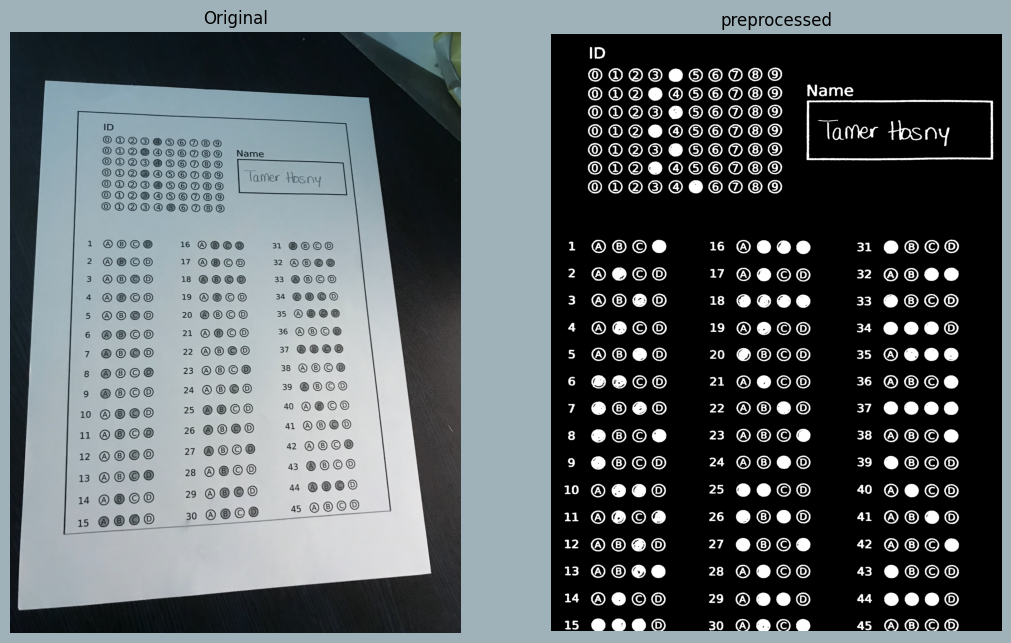

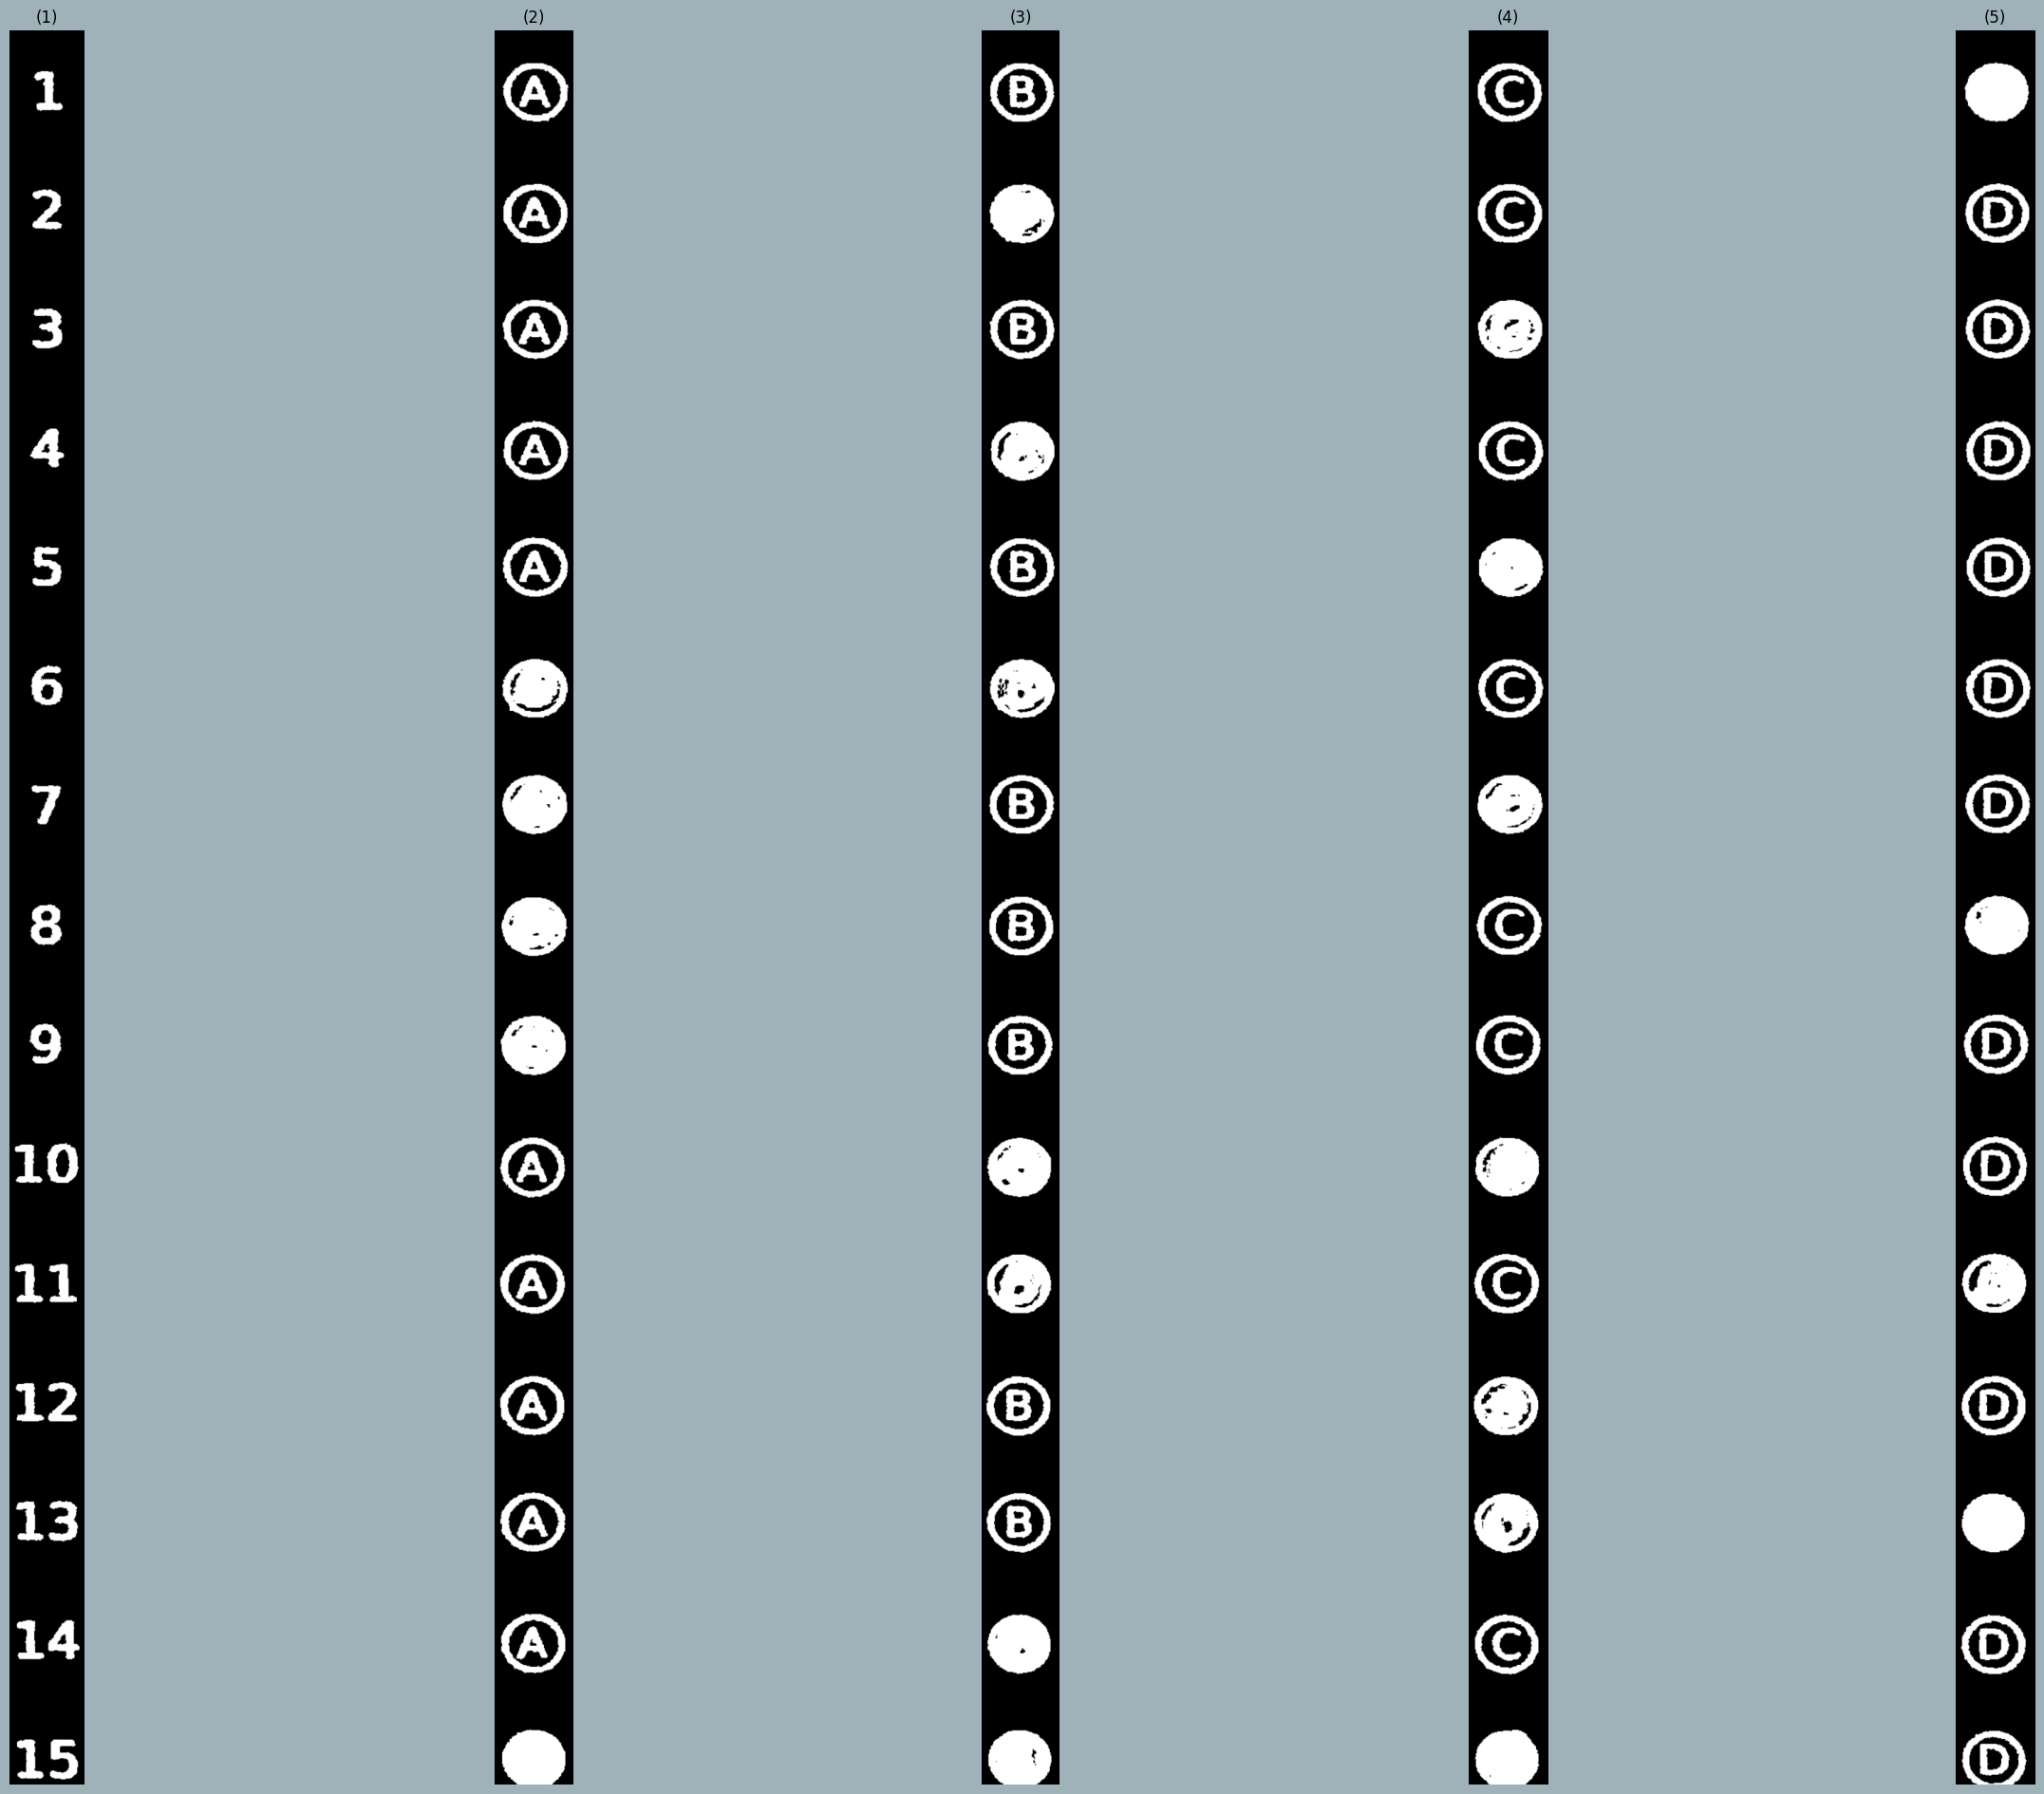

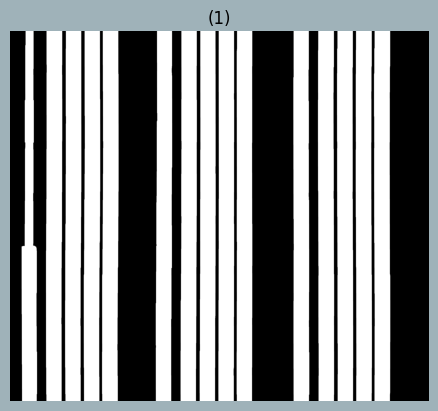

In [21]:
image_path='./samples/4 (2).jpg'
img=cv2.imread(image_path, cv2.IMREAD_COLOR)
shifted=perspective_transform(img,binary=0)
shifted2=perspective_transform(shifted,binary=0)
inverted=invert_image(img)
cf.show_images([img,inverted],['Original','preprocessed'])
# cf.show_images([shifted2,inverted],['Corrected','Inverted'])
bubble,id=pre_process(img)
# cf.show_images([bubble,id],['Bubbles','Id + Name'])
id2,name=pre_process_id(id)
# cf.show_images([id2,name],['Id','Name'])
lines=extract_contour_regions(bubble,bubble_vertical_mask(bubble))
# lines.insert(0,bubble_vertical_mask(bubble))
while(len(lines)>5):
    lines.pop()
cf.show_images(lines)
cf.show_images([bubble_vertical_mask(bubble)])